# Блокнот для изучения метода генерации полей

Цель блокнота - сгенерировать fractional Brownian motion (fBm) — случайное поле с фрактальной структурой и заданным показателем Хёрста $H$.

### Схема процесса

```
Белый шум (Fourier)
        ↓
Степенной фильтр |k|^{-(H + d/2)}
        ↓
Обратное FFT
        ↓
fractional Brownian motion
```

### 1. Белый шум в Фурье-пространстве

Формируем белый гауссов шум:

$
\hat{\xi}(\mathbf{k}) = \xi_1(\mathbf{k}) + i,\xi_2(\mathbf{k}),
\quad
\xi_1, \xi_2 \sim \mathcal{N}(0,1)
$

Свойство белого шума:

$
\mathbb{E}|\hat{\xi}(\mathbf{k})|^2 = \text{const}
$


### 2. Пространство волновых чисел

Каждой частоте Фурье соответствует вектор:

$
\mathbf{k} = (k_1, \dots, k_d)
$

и его длина:

$
|\mathbf{k}| = \sqrt{k_1^2 + \dots + k_d^2}
$


### 3. Степенной спектр fBm

Для fractional Brownian motion в размерности $d$ спектральная плотность мощности имеет вид:

$
P_{\text{fBm}}(\mathbf{k})
;\propto;
|\mathbf{k}|^{-(2H + d)}
$

где:

* $H \in (0,1)$ — показатель Хёрста
* $d$ — размерность пространства


### 4. Амплитудный фильтр

Так как умножаеся амплитуда, а не мощность, используется корень:

$
S(\mathbf{k}) ;\propto;
|\mathbf{k}|^{-(H + d/2)}
$

И формируем сигнал - окрашенный белый шум:

$
\hat{u}(\mathbf{k}) = S(\mathbf{k}) \cdot \hat{\xi}(\mathbf{k})
$

### 5. Нулевая частота

В точке $\mathbf{k} = 0$:

$
|\mathbf{k}|^{-(H + d/2)} \to \infty
$

Поэтому мы принудительно задаём: $\hat{u}(0) = 0$, чтобы устранить расходимость и зафиксировать среднее значение поля.


### 6. Обратное преобразование Фурье

Теперь выполняем обратное преобразование Фурье:

$
u(\mathbf{x}) =
\mathcal{F}^{-1}
\left[
\hat{\xi}(\mathbf{k}),|\mathbf{k}|^{-(H + d/2)}
\right]
$

Результатом будет **fractional Brownian motion**.


### Anisotropic fBm
Для генерации поля, у которого разный Hurst по осям  - anisotropic fBm пункты 2-5 изменены.

Anisotropic fBm:

$
\mathbb{E}|X(x + h e_i) - X(x)|^2 \sim |h|^{2H_i}
$

* по оси $x$ — $H_x$,
* по $y$ — $H_y$,
* по $z$ — $H_z$.

Для анизотропного fBm используется сепарабельный спект (fractional Brownian sheet):

$
S(\mathbf{k}) \propto \prod_{i=1}^{d} |k_i|^{-(H_i + 1/2)}
$

### **Источники**:

* Timmer, J., & Koenig, M. (1995),
  *On generating power law noise*. Astronomy and Astrophysics, v. 300, p. 707, 300, 707.

* Dietrich & Newsam (1997),
  *Fast and Exact Simulation of Stationary Gaussian Processes through Circulant Embedding of the Covariance Matrix*
  [https://doi.org/10.1137/S1064827592240555](https://doi.org/10.1137/S1064827592240555)

* Mandelbrot & Van Ness (1968),
  *Fractional Brownian motions, fractional noises and applications*
  [https://doi.org/10.1137/1010093](https://doi.org/10.1137/1010093)

### Нормировка

Чаще всего поле масштабируют, это обеспечивает универсальность метода в экспериментах. Для этого в функции `ndfnoise` есть параметр `normalize`, который по умолчанию имеет значение `True`.

$
X_H(x) \leftarrow \frac{X_H(x) - \mathbb{E}[X_H]}{\sqrt{\mathrm{Var}(X_H)}}.
$

# 3. Пример использования

В следующих разделах используется метод для одинакового Hurst по всем осям, это изотропный случай, когда одинаковая шероховатость во всех направлениях.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from StatTools.generators.ndfnoise_generator import ndfnoise
from StatTools.analysis.dfa import DFA

In [2]:
%%time
f2 = ndfnoise((2**9, 2**9, 2**9), hurst=1)

CPU times: user 2.78 s, sys: 847 ms, total: 3.63 s
Wall time: 4.17 s


In [3]:
def dfa_sliced(arr: np.ndarray) -> np.ndarray:
    """
    Calculate DFA for z slaces.
    """
    if len(arr.shape) != 3:
        h_values = DFA(np.diff(arr)).find_h()
        return h_values
    ny = arr.shape[1]
    nz = arr.shape[2]
    results = np.zeros((nz, ny))

    for i in tqdm(range(nz), desc="sliced 3d DFA"):
        slice_2d = np.diff(arr[:, :, i])
        h_values = DFA(slice_2d).find_h()
        results[i] = h_values
        if i > 10:
            break
    return results

## 2d field

In [4]:
size = 2**10
for h in [0.5, 0.75, 1.0, 1.25, 1.5]:
    f = ndfnoise((size, size), hurst=h)
    res = dfa_sliced(f)
    print(f"Ht={h}, Hf Mean +- Std: {np.mean(res):.2f} +- {np.std(res):.2f}")
print(f"Field shape is {f.shape}")

Ht=0.5, Hf Mean +- Std: 0.65 +- 0.03
Ht=0.75, Hf Mean +- Std: 0.85 +- 0.04
Ht=1.0, Hf Mean +- Std: 1.07 +- 0.04
Ht=1.25, Hf Mean +- Std: 1.32 +- 0.05
Ht=1.5, Hf Mean +- Std: 1.54 +- 0.05
Field shape is (1024, 1024)


### Visualization

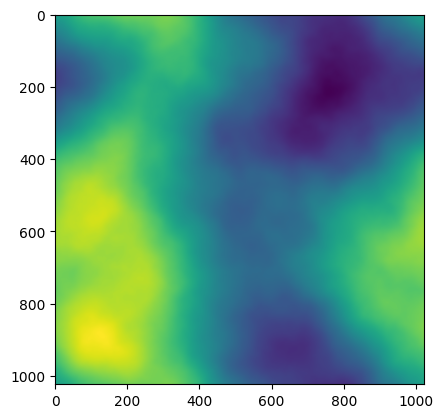

In [5]:
plt.imshow(f)
plt.show()

## 3d field

In [6]:
# Note: Only 10 first slices are calculated in `dfa_sliced` for speed up.
size = 2**9
for h in [0.5, 0.75, 1.0, 1.25, 1.5]:
    f = ndfnoise((size, size, size), hurst=h)
    res = dfa_sliced(f)[0:10]
    print(f"Ht={h}, Hf Mean +- Std: {np.mean(res):.2f} +- {np.std(res):.2f}")
print(f"Field shape is {f.shape}")

sliced 3d DFA:   2%|▏         | 11/512 [00:36<27:50,  3.33s/it]


Ht=0.5, Hf Mean +- Std: 0.68 +- 0.05


sliced 3d DFA:   2%|▏         | 11/512 [00:36<27:49,  3.33s/it]


Ht=0.75, Hf Mean +- Std: 0.87 +- 0.04


sliced 3d DFA:   2%|▏         | 11/512 [00:36<27:46,  3.33s/it]


Ht=1.0, Hf Mean +- Std: 1.07 +- 0.06


sliced 3d DFA:   2%|▏         | 11/512 [00:36<27:44,  3.32s/it]


Ht=1.25, Hf Mean +- Std: 1.35 +- 0.06


sliced 3d DFA:   2%|▏         | 11/512 [00:36<27:56,  3.35s/it]

Ht=1.5, Hf Mean +- Std: 1.56 +- 0.06
Field shape is (512, 512, 512)


### Visualization

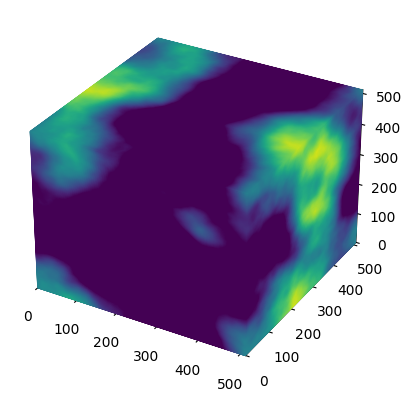

In [7]:
Nx, Ny, Nz =  f.shape

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
idx = f.shape[0]-1

Y, Z = np.meshgrid(np.arange(Ny), np.arange(Nz), indexing='ij')
X = np.full_like(Y, idx)

ax.plot_surface(
    X, Y, Z,
    facecolors=plt.cm.viridis(f[idx, :, :] / f.max()),
    rstride=1, cstride=1,
    shade=False
)

X, Z = np.meshgrid(np.arange(Nx), np.arange(Nz), indexing='ij')
Y = np.zeros_like(X)

ax.plot_surface(
    X, Y, Z,
    facecolors=plt.cm.viridis(f[:, 0, :] / f.max()),
    rstride=1, cstride=1,
    shade=False
)

X, Y = np.meshgrid(np.arange(Nx), np.arange(Ny), indexing='ij')
Z = np.full_like(Y, idx)

С = ax.plot_surface(
    X, Y, Z,
    facecolors=plt.cm.viridis(f[:, :, 0] / f.max()),
    rstride=1, cstride=1,
    shade=False
)
# fig.colorbar(C, ax=ax)
ax.set_xlim(0, Nx)
ax.set_ylim(0, Ny)
ax.set_zlim(0, Nz)

plt.show()

## Different H

В этом разделе показана генерация поля, у которого разный Hurst по осям  - anisotropic fBm.

In [8]:
size = 2**10
h_list = [0.5, 0.75, 1.0, 1.25, 1.5]
for i,h in enumerate(h_list):
    if i == 3:
        break
    f = ndfnoise((size, size), hurst=(h, h_list[-i-1]))
    resx = dfa_sliced(f.T)
    resy = dfa_sliced(f)
    print(f"Ht={h}, Hx Mean +- Std: {np.mean(resx):.2f} +- {np.std(resx):.2f}")
    print(f"Ht={h_list[-i-1]}, Hy Mean +- Std: {np.mean(resy):.2f} +- {np.std(resy):.2f}")
print(f"Field shape is {f.shape}")

/Users/a1/Documents/GitHub/StatTools/StatTools/generators/ndfnoise_generator.py:51: RuntimeWarning: divide by zero encountered in reciprocal
  S *= np.abs(f.reshape(reshape)) ** (-(hurst[i] + 0.5))
/Users/a1/Documents/GitHub/StatTools/StatTools/generators/ndfnoise_generator.py:55: RuntimeWarning: divide by zero encountered in power
  S *= np.abs(f_last.reshape((1,) * (dim - 1) + (-1,))) ** (-(hurst[-1] + 0.5))


Ht=0.5, Hx Mean +- Std: 0.64 +- 0.01
Ht=1.5, Hy Mean +- Std: 1.56 +- 0.04


/Users/a1/Documents/GitHub/StatTools/StatTools/generators/ndfnoise_generator.py:51: RuntimeWarning: divide by zero encountered in power
  S *= np.abs(f.reshape(reshape)) ** (-(hurst[i] + 0.5))


Ht=0.75, Hx Mean +- Std: 0.83 +- 0.02
Ht=1.25, Hy Mean +- Std: 1.29 +- 0.03
Ht=1.0, Hx Mean +- Std: 1.08 +- 0.03
Ht=1.0, Hy Mean +- Std: 1.08 +- 0.03
Field shape is (1024, 1024)


### Visualization

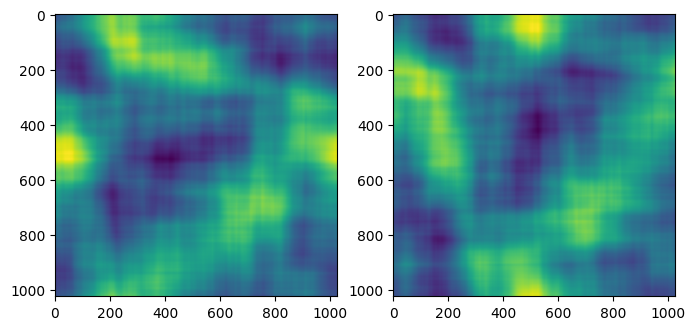

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(f)
ax[1].imshow(f.T)
plt.show()